In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy
from scipy import signal
from tensorflow.keras.layers import Input,Dense,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pickle

In [2]:
#!unzip train.csv*.zip
#!unzip test.csv*.zip

In [2]:
test_data=pd.read_csv('test.csv')
data=pd.read_csv('train.csv')
print(data.shape)
data.head()

(4867421, 28)


,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [4]:
print(data.experiment.unique())
print(test_data.experiment.unique())

['CA' 'DA' 'SS']
['LOFT']


In [5]:
data.isnull().sum()

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
 #   Column      Dtype  
---  ------      -----  
 0   crew        int64  
 1   experiment  object 
 2   time        float64
 3   seat        int64  
 4   eeg_fp1     float64
 5   eeg_f7      float64
 6   eeg_f8      float64
 7   eeg_t4      float64
 8   eeg_t6      float64
 9   eeg_t5      float64
 10  eeg_t3      float64
 11  eeg_fp2     float64
 12  eeg_o1      float64
 13  eeg_p3      float64
 14  eeg_pz      float64
 15  eeg_f3      float64
 16  eeg_fz      float64
 17  eeg_f4      float64
 18  eeg_c4      float64
 19  eeg_p4      float64
 20  eeg_poz     float64
 21  eeg_c3      float64
 22  eeg_cz      float64
 23  eeg_o2      float64
 24  ecg         float64
 25  r           float64
 26  gsr         float64
 27  event       object 
dtypes: float64(24), int64(2), object(2)
memory usage: 1.0+ GB


Text(0, 0.5, 'Frequency')

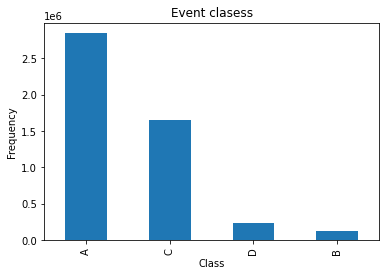

In [7]:
count_class=pd.value_counts(data['event'],sort=True)
count_class.plot(kind='bar')
plt.title("Event clasess")
plt.xlabel("Class")
plt.ylabel("Frequency")

1.This bar plot explains how to events are classified. In x-axis we have all the 4 events. In y-axis we have frequncy of count of all the event ploted. From this plot all the point are not eventually in numbers.

2.From this I concluded that the events are imbalanced.

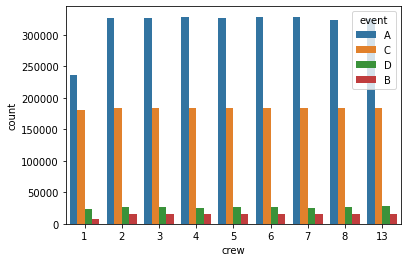

In [8]:
sns.countplot(x="crew",hue="event",data=data)

This plot says the count of crew and how they are balanced. Here all crew id are balanced for every event, crew_id 1 is alone slightly low and that won't create impact much to the model.

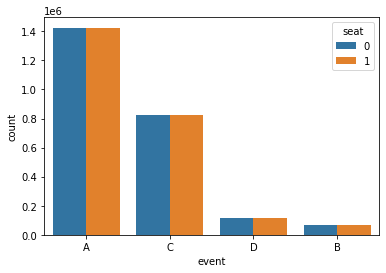

In [9]:
sns.countplot(x="event",hue="seat",data=data)

This plot says the count of seat and how they are balanced.

Here all seat are balanced for every event.


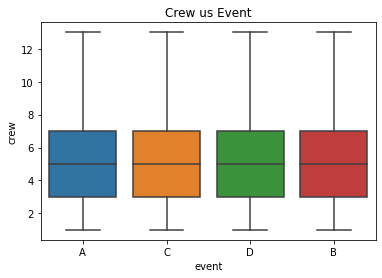

In [10]:
sns.boxplot(data["event"],data["crew"],width=0.8)
plt.title("Crew us Event")
plt.show()

Here we have plotted how crew impacts event using box plot. here the points are not separable. individually it will not create a better feature for the model.

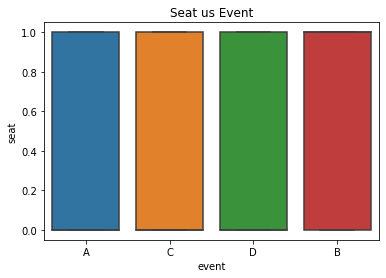

In [11]:
sns.boxplot(data["event"],data["seat"],width=0.8)
plt.title("Seat us Event")
plt.show()

Here we have plotted how seat impacts event using box plot. here the points are not separable. individually it will not create a better feature for the model.

In [12]:
data.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')

In [13]:
features=[ 'ecg', 'r', 'gsr']

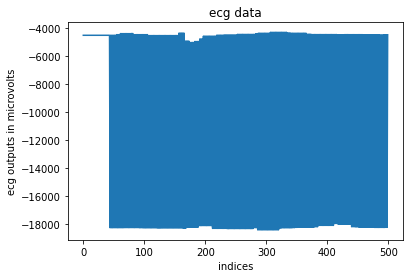

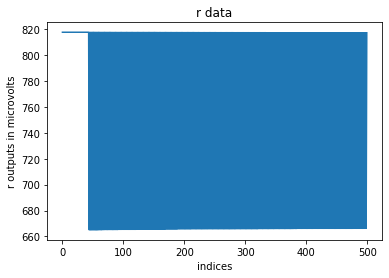

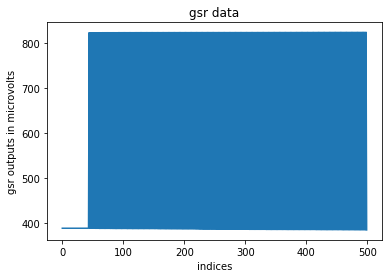

In [14]:
raw_data= data.loc[(data['experiment'] == 'CA')]
raw_data.sort_values(by="time")
for i in features:
    plt.plot(raw_data[i][0:500])
    plt.title(i+" data")
    plt.xlabel("indices")
    plt.ylabel(i+" outputs in microvolts")
    plt.show()

Here we have plottes the point for feature ecg,r,gsr. from the plot its clear that these features were highly rich in noise.

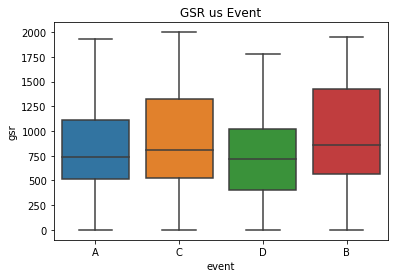

In [15]:
sns.boxplot(data["event"],data["gsr"],width=0.8)
plt.title("GSR us Event")
plt.show()

1.Here the points are separable, if point are very high it will be event C or D.If points are very low it will event D.

2.From this I concluded that this feature will be very usefull for the model


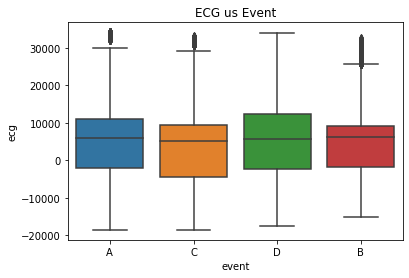

In [16]:
sns.boxplot(data["event"],data["ecg"],width=0.8)
plt.title("ECG us Event")
plt.show()

1.Here there are some outliers,removing those outlier will be losing some important points. Here points are separable in some point.

2.Removing the noisy data from ECG might give better result

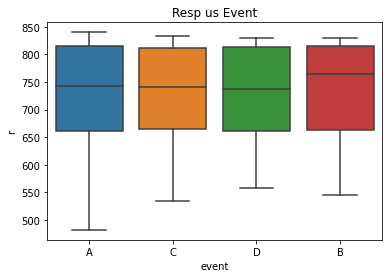

In [17]:
sns.boxplot(data["event"],data["r"],width=0.8)
plt.title("Resp us Event")
plt.show()

1.Here points are not separable. It might be not seaprable because of noisy data

2.Removing the noisy data from ECG might gives better result

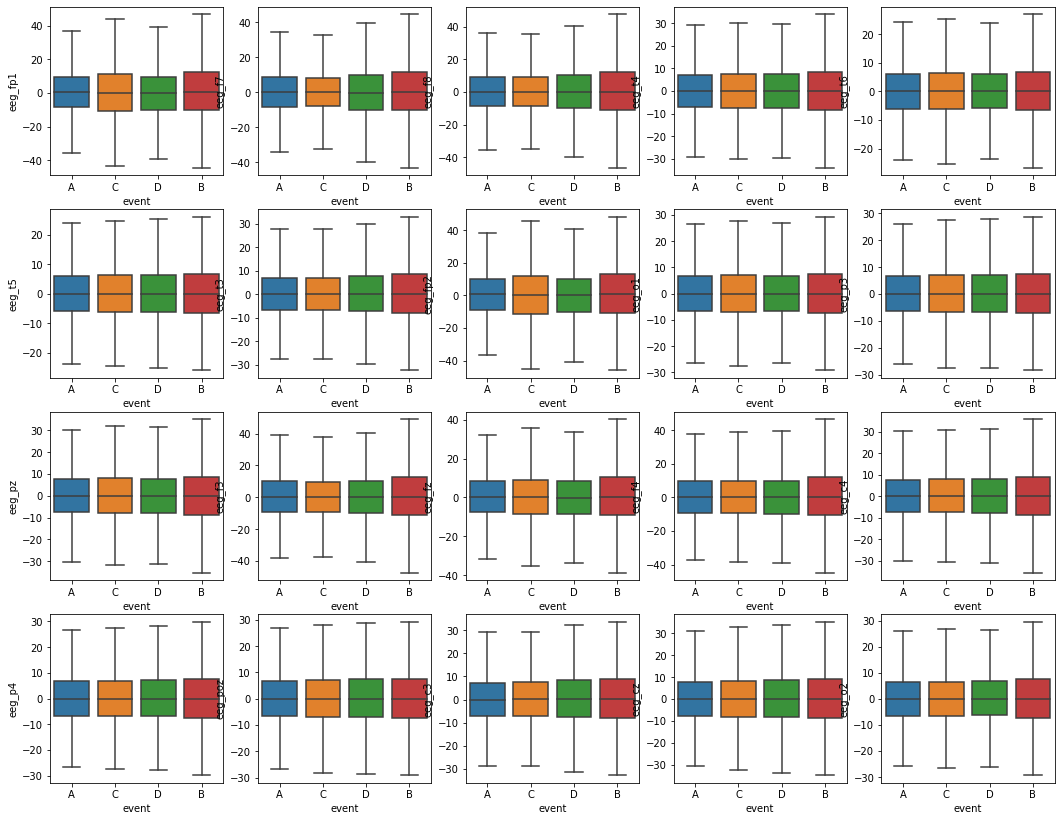

In [18]:
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2']
plt.figure(figsize=(18,18))
plt.title('EEG DATA ANALYSIS')
for i,j in enumerate(eeg_features):
     plt.subplot(5,5,i+1)
     sns.boxplot(x='event',y=j,data=data,showfliers=False)
plt.show()

Here we plotted all eeg features and how its related to event data. and  now from the plot  we can all the features non separable. 

It is very dificult for the model make use these feature.As they were not separable

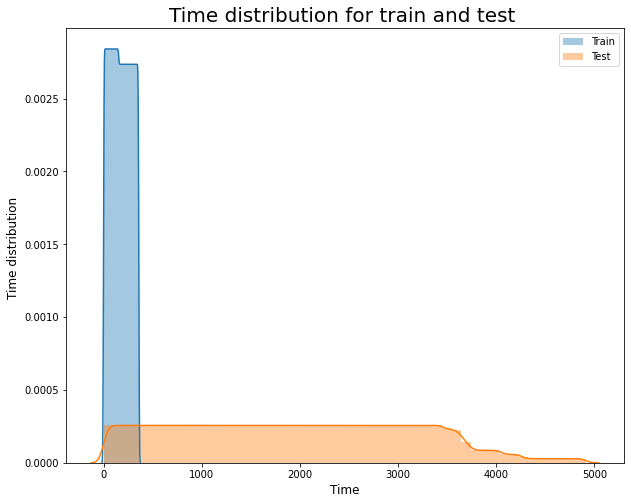

In [19]:
plt.figure(figsize=(10,8))
sns.distplot(data['time'],label='Train')
sns.distplot(test_data['time'],label='Test')
plt.legend()
plt.title("Time distribution for train and test ",fontsize=20)
plt.xlabel("Time" ,fontsize=12)
plt.ylabel("Time distribution ",fontsize=12)
plt.show()

Here we visualizing the data of feature time for both train and test data. 
I concluded that training time feature will not usefull for test data.

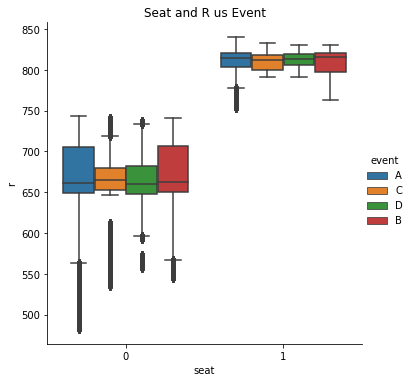

In [20]:
sns.catplot(x="seat", y="r", hue="event", kind="box", data=data);
plt.title('Seat and R us Event')
plt.show()

Here from this plot , there are some outliers, we cannot remove those outliers so that we might lose some important data.

Here point are separable , when seat is one and r is greater than 830 it will be event A. when seat is one and r is less than 780 it will be event B.

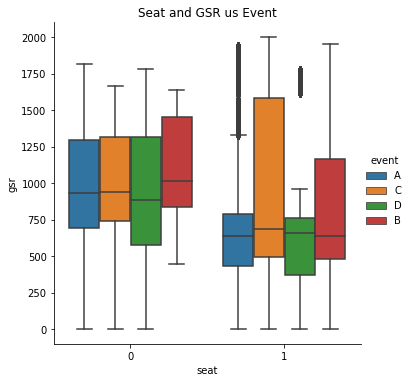

In [21]:
sns.catplot(x="seat", y="gsr", hue="event", kind="box", data=data);
plt.title('Seat and GSR us Event')
plt.show()

Here from this plot , there are some outliers, we cannot remove those outliers so that we might lose some important data.

Here point are separable , when seat is zero and gsr is greater than 1750 it will be event A.

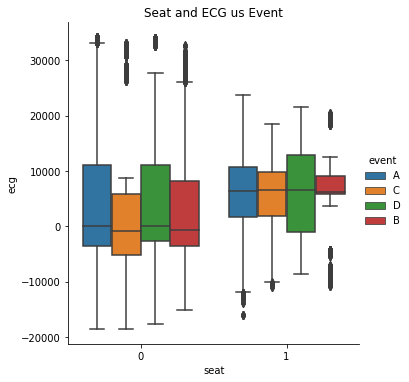

In [22]:
sns.catplot(x="seat", y="ecg", hue="event", kind="box", data=data);
plt.title('Seat and ECG us Event')
plt.show()

Here from this plot , there are some outliers, we cannot remove those outliers so that we might lose some important data.

Here point are separable , when seat is zero and gsr is greater than 22000 it will be event A.
when seat is one  and gsr is greater than 20000 and lesser than 10,000 it will be event A.

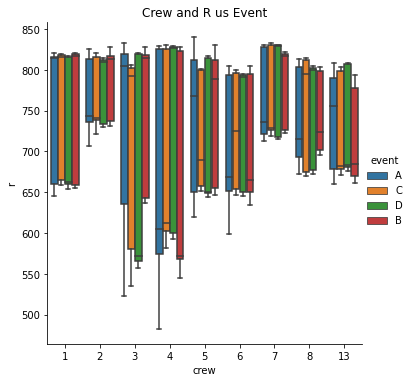

In [23]:
sns.catplot(x="crew", y="r", hue="event", kind="box", data=data);
plt.title('Crew and R us Event')
plt.show()

Here point are separable ,for every crew the events were differing for different points . In test data also we have same crew id so this relation will separate the events and give a result.

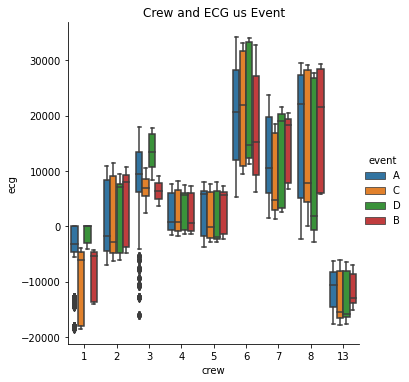

In [24]:
sns.catplot(x="crew", y="ecg", hue="event", kind="box", data=data);
plt.title('Crew and ECG us Event')
plt.show()

Here point are separable ,for every crew the events were differing for different points . In test data also we have same crew id so this relation will separate the events and give a result.

Here , there are some outliers, we cannot remove those outliers so that we might lose some important data.

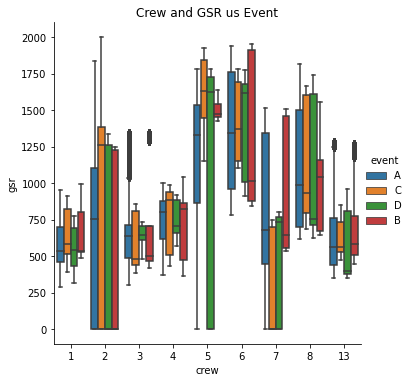

In [25]:
sns.catplot(x="crew", y="gsr", hue="event", kind="box", data=data);
plt.title('Crew and GSR us Event')
plt.show()

Here point are separable ,for every crew the events were differing for different points . In test data also we have same crew id so this relation will separate the events and give a result.

Here , there are some outliers, we cannot remove those outliers so that we might lose some important data.

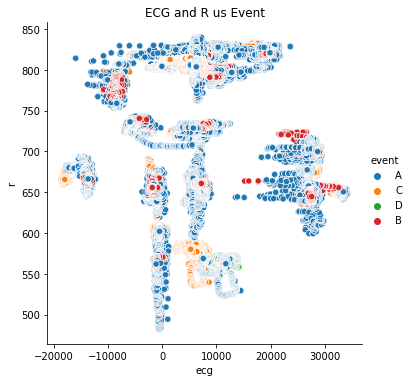

In [26]:
sns.relplot(x="ecg", y="r", hue="event", data=data);
plt.title('ECG and R us Event')
plt.show()

Here the points are separable when comparing r and ecg feature. these feature will be usefull for predicting the test data.

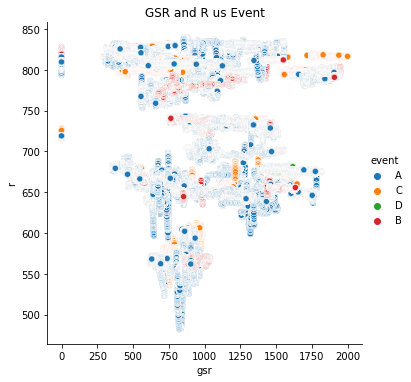

In [27]:
sns.relplot(x="gsr", y="r", hue="event", data=data);
plt.title('GSR and R us Event')
plt.show()

Here the points are separable when comparing r and gsr feature. these feature will be usefull for predicting the test data.


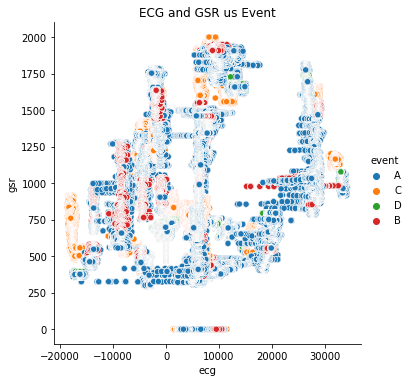

In [28]:
sns.relplot(x="ecg", y="gsr", hue="event", data=data);
plt.title('ECG and GSR us Event')
plt.show()

Here the points are separable when comparing ecg and gsr feature. these feature will be usefull for predicting the test data.


In [3]:
#https://stackoverflow.com/questions/35588782/how-to-average-a-signal-to-remove-noise-with-python
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def remove_noise(data,f):
    N=5    #filter order
    Wn=f #Cutoff frequency
    b,a = signal.butter(N,Wn,fs=256)
    return signal.filtfilt(b,a,data)

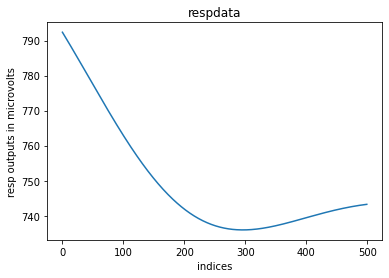

In [4]:
filtered_data=remove_noise(data['r'],0.5)
filtered_data_test=remove_noise(test_data['r'],0.5)
data["filtered_r"]=filtered_data
test_data["filtered_r"]=filtered_data_test
raw_data= data.loc[data['experiment'] == 'CA']
raw_data.sort_values(by="time")
plt.plot(raw_data['filtered_r'][0:500])
plt.title("respdata")
plt.xlabel("indices")
plt.ylabel("resp outputs in microvolts")
plt.show()

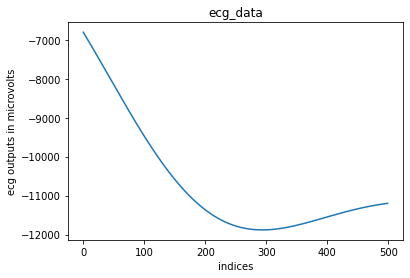

In [5]:
filtered_data=remove_noise(data['ecg'],0.5)
filtered_data_test=remove_noise(test_data['ecg'],0.5)
data["filtered_ecg"]=filtered_data
test_data["filtered_ecg"]=filtered_data_test
raw_data= data.loc[data['experiment'] == 'CA']
raw_data.sort_values(by="time")
plt.plot(raw_data['filtered_ecg'][0:500])
plt.title("ecg_data")
plt.xlabel("indices")
plt.ylabel("ecg outputs in microvolts")
plt.show()

In [6]:
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2']
pca_features= data.loc[:, eeg_features]
pca_features_test=test_data.loc[:,eeg_features]
print(pca_features.shape)
pca_features.head(1)

(4867421, 20)


,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2
0,-5.28545,26.775801,-9.52731,-12.7932,16.7178,33.737499,23.712299,-6.69587,29.2321,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.2019,20.5968,-3.95115,14.5076


In [7]:
pca = PCA(n_components=2)
Components = pca.fit_transform(pca_features)
Components_test = pca.transform(pca_features_test)
pickle.dump(pca, open('pca.sav', 'wb'))
principalDf =pd.DataFrame(data=Components,columns=['component_1','component_2'])
principalDf_test =pd.DataFrame(data=Components_test,columns=['component_1','component_2'])
principalDf.head(1)

,component_1,component_2
0,-28.838463,-7.912255


In [8]:
#Auto Encoder
inputs=Input(shape=(20,))
#encoder 1
x=Dense(17)(inputs)
x=LeakyReLU()(x)
#encoder 2
x=Dense(14)(inputs)
x=LeakyReLU()(x)
#encoder 3
x=Dense(11)(x)
x=LeakyReLU()(x)
#encoder 4
x=Dense(8)(inputs)
x=LeakyReLU()(x)
#hidden
hidden = Dense(5)(x)
#decoder 1
x=Dense(8)(x)
x=LeakyReLU()(x)
#decoder 2
x=Dense(11)(inputs)
x=LeakyReLU()(x)
#decoder 3
x=Dense(14)(inputs)
x=LeakyReLU()(x)
#decoder 4
x=Dense(17)(x)
x=LeakyReLU()(x)
#output
output = Dense(20,activation='linear')(x)

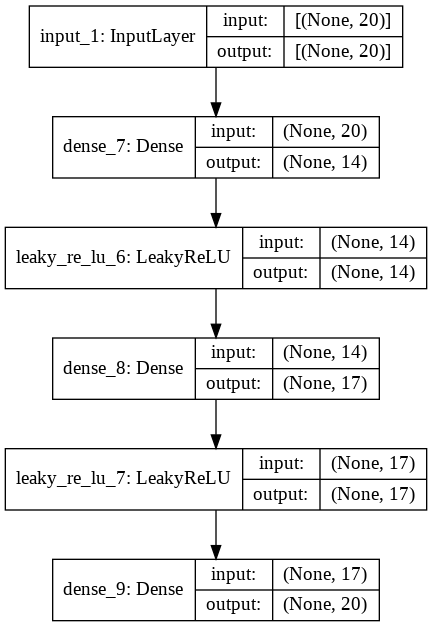

In [9]:
Autoencoder = Model(inputs=inputs,outputs=output)
plot_model(Autoencoder,'Autoencoder.png',show_shapes=True)

In [11]:
Auto_encoder=Model(inputs=inputs,outputs=output)
Auto_encoder.compile(optimizer='adam',loss='mse')
history = Auto_encoder.fit(pca_features,pca_features,epochs=200, batch_size=500, verbose=2)

Epoch 1/200
9735/9735 - 17s - loss: 48.0663
Epoch 2/200
9735/9735 - 16s - loss: 29.2717
Epoch 3/200
9735/9735 - 16s - loss: 26.5858
Epoch 4/200
9735/9735 - 16s - loss: 24.6740
Epoch 5/200
9735/9735 - 16s - loss: 23.6296
Epoch 6/200
9735/9735 - 16s - loss: 22.9841
Epoch 7/200
9735/9735 - 17s - loss: 22.5910
Epoch 8/200
9735/9735 - 16s - loss: 22.3900
Epoch 9/200
9735/9735 - 16s - loss: 22.2281
Epoch 10/200
9735/9735 - 16s - loss: 22.1203
Epoch 11/200
9735/9735 - 16s - loss: 21.9545
Epoch 12/200
9735/9735 - 16s - loss: 21.8273
Epoch 13/200
9735/9735 - 16s - loss: 21.6421
Epoch 14/200
9735/9735 - 16s - loss: 21.4748
Epoch 15/200
9735/9735 - 16s - loss: 21.3275
Epoch 16/200
9735/9735 - 16s - loss: 21.1880
Epoch 17/200
9735/9735 - 16s - loss: 21.0891
Epoch 18/200
9735/9735 - 16s - loss: 21.0131
Epoch 19/200
9735/9735 - 16s - loss: 20.8754
Epoch 20/200
9735/9735 - 16s - loss: 20.7645
Epoch 21/200
9735/9735 - 16s - loss: 20.6572
Epoch 22/200
9735/9735 - 16s - loss: 20.5842
Epoch 23/200
9735/9

In [12]:
feature_encoder=Model(inputs=inputs,outputs=hidden)
feature_encoder.save('encoder.h5')

In [13]:
feature_encoder=tf.keras.models.load_model('encoder.h5')
train_encoders=feature_encoder.predict(pca_features)
test_encoders=feature_encoder.predict(pca_features_test)
eeg_encoder =pd.DataFrame(data=train_encoders,columns=['eeg_encoder_1','eeg_encoder_2','eeg_encoder_3','eeg_encoder_4','eeg_encoder_5'])
eeg_encoder_test =pd.DataFrame(data=test_encoders,columns=['eeg_encoder_1','eeg_encoder_2','eeg_encoder_3','eeg_encoder_4','eeg_encoder_5'])
eeg_encoder.head(1)

,eeg_encoder_1,eeg_encoder_2,eeg_encoder_3,eeg_encoder_4,eeg_encoder_5
0,-19.271492,10.024624,-19.160746,13.541881,0.668523


In [14]:
#droping ecg, r as we created new features with them by clearing noise
#droping all eeg features as we creted new features with them.
#droping experiment column as there is no relation with test.csv
#droping time column as there is no use to model from the analysis of test and train data

features=['time','ecg','r','eeg_fp1', 'eeg_f7', 'eeg_f8','experiment',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2']
print('Before droping:',data.shape)
for i in features:
    data= data.drop(i,axis=1) 
    test_data= test_data.drop(i,axis=1) 
print('After droping train:',data.shape)
print('After droping test:',test_data.shape)
data.head(1)

Before droping: (4867421, 30)
After droping train: (4867421, 6)
After droping test: (17965143, 6)


,crew,seat,gsr,event,filtered_r,filtered_ecg
0,1,1,388.829987,A,792.382457,-6808.661746


In [15]:
#conacting all old and new features
X_data=pd.concat([data,eeg_encoder,principalDf],axis=1)
X_data_test=pd.concat([test_data,eeg_encoder_test,principalDf_test],axis=1)
X_data.head(1)

,crew,seat,gsr,event,filtered_r,filtered_ecg,eeg_encoder_1,eeg_encoder_2,eeg_encoder_3,eeg_encoder_4,eeg_encoder_5,component_1,component_2
0,1,1,388.829987,A,792.382457,-6808.661746,-19.271492,10.024624,-19.160746,13.541881,0.668523,-28.838463,-7.912255


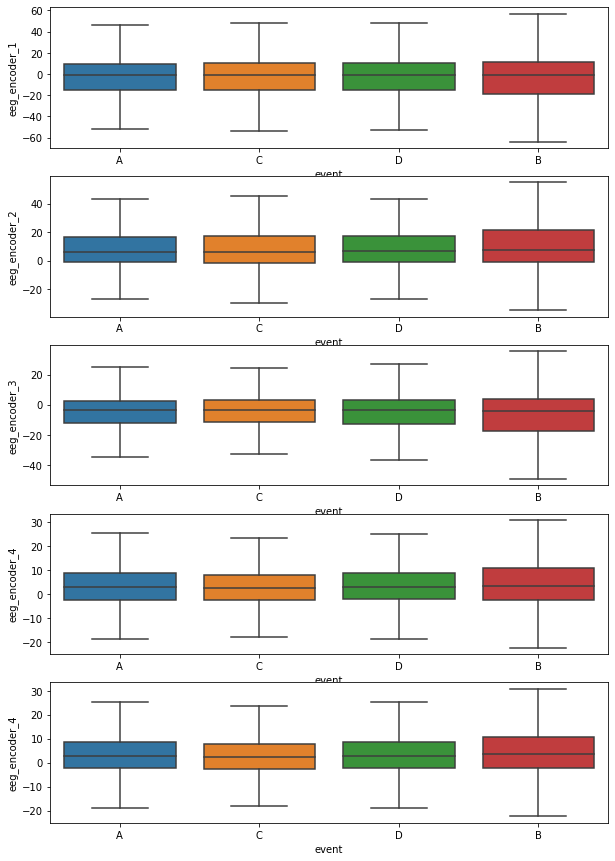

In [17]:
eeg_encoder_features=['eeg_encoder_1', 'eeg_encoder_2', 'eeg_encoder_3','eeg_encoder_4','eeg_encoder_4']
plt.figure(figsize=(10,15))
plt.title('EEG Encoder Data Analysis')
for i,j in enumerate(eeg_encoder_features):
     plt.subplot(5,1,i+1)
     sns.boxplot(x='event',y=j,data=X_data,showfliers=False)
plt.show()

Here from the plots the points are separable some part. when the eeg_ecncoders are higher they are with B event.

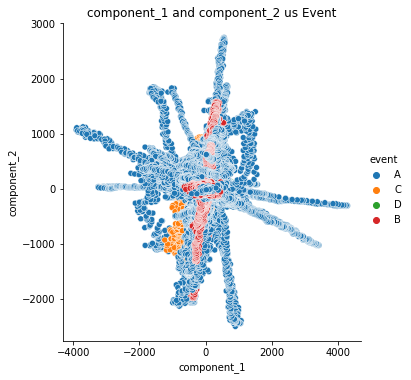

In [18]:
sns.relplot(x="component_1", y="component_2", hue="event", data=X_data);
plt.title('component_1 and component_2 us Event')
plt.show()

Here from the plots the points are separable. when the component_1 points are greater than 1080 it will be A state . likewise many points separable in this separable.

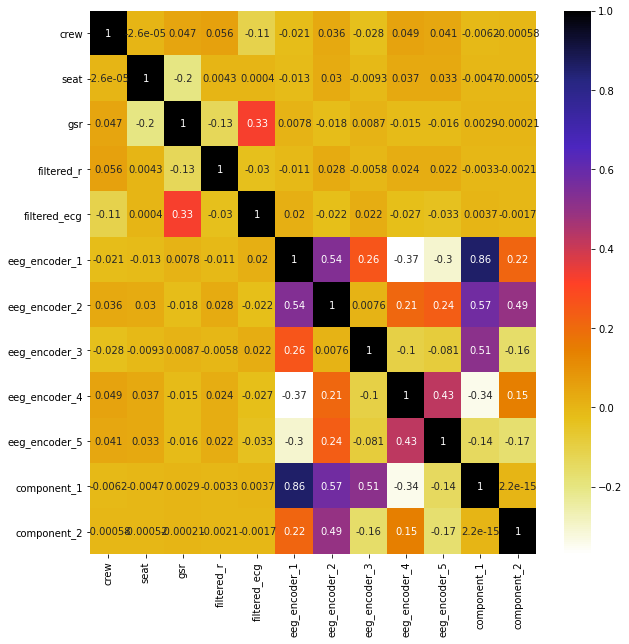

In [19]:
plt.figure(figsize=(10,10))
cor=X_data.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

Here I have plotted the heat for the data , how the features are coorelated to each other. here we can see the weights of the correlation.

Here filtered_ecg and gsr are the most correlated feature in this data . cooreetion of 0.33.

In [16]:
X_data.to_csv('preprocessed_train_data.csv',index=False)
X_data_test.to_csv('preprocessed_test_data.csv',index=False)

# EDA SUMMARY

             1.Given dataset, Events(outout feature) are not balanced. 
             2.Every crew id and seat were balanced with theirs events.
             3.Here we have find more noisy data in column GSR,ECG,r. removing noise will give much better result.
             4.Individually seat and crew dosent affected much the events.
             5.But from the bivariate anlysisis of seat with GSR,ECG,R. the seat feature are separable for some  points   in events.
             6.And the bivariate anlysisis of event with GSR,ECG,R. the event feature are saparable  for  some  points in   events.
             7.Experiment  feature is a categorical feature , thr datas are completely diffferent from  train and test.  so it will be not usefull for test data.
             8.In univariate analysis of ECG,GSR,r with events. As the data are so noisy the points are not separable.then GSR feature is separable in some points. It will be very usefull feature.
             9.In bivariate analysis of ECG,GSR,r with events. the pointa are separable in some area.
             10.In eeg there are 20 features , each are not that much separable for the events. they may be usefull when they were reduced to few features using PCA.             

# Feature Engineering 

             1.Removed the noisy data from ECG, r. As they were high rich in noise.
             2.For 20 eef feature , I have reduced to 2 component by principal component analysis.As there are more number feature in eeg. this will reduce the dimensionality
             3.and again with the eeg features , I have trained with auto encoders. after training I have taken the decoder input hidden feature  and consider as a feature.
             4.droped the feature experoment and time which wont be usefull for test data. 
             5.splitted the train data into train and test.
             6.now I have standarized the feature has larger values.